## Transfer Learning - ResNet50

In this approach we try and leverage large pre-trained Convolutional Neural Networks for tackling the classification problem over all 10 genres

In [1]:
#importing google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
#setting the working directory
%cd /gdrive/MyDrive/polimi/NAML/NAML_proj/

/gdrive/MyDrive/polimi/NAML/NAML_proj


In [3]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
import random
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import librosa

tfk = tf.keras
tfkl = tf.keras.layers
seed = 42

In [20]:
dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
n_genres = 10

for genre, genre_number in genres.items():
    for filename in os.listdir(f'dataset_old/genres/{genre}'):
        songname = f'dataset_old/genres/{genre}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=29.7)
        ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512)
        ps = librosa.power_to_db(ps**2)
        dataset.append( (ps, genre_number) )
    print(str(genre+' done'))

blues done
classical done
country done
disco done
hiphop done
jazz done
metal done
pop done
reggae done
rock done


In [21]:
order = np.arange(start = 0, stop = 100, step = 1)

np.random.seed(seed)

training = []
validation = []
test = []

for i in range(n_genres):
  shuffle = np.random.permutation(order)
  for k in range(70):
    training.append(dataset[i*100 + shuffle[k]])
  for l in range(20):
    validation.append(dataset[i*100 + shuffle[l+70]])
  for m in range(10):
    test.append(dataset[i*100 + shuffle[m+90]])

In [22]:
X_train, Y_train = zip(*training)
X_valid, Y_valid = zip(*validation)
X_test, Y_test = zip(*test)

X_train = np.array([x.reshape( (128, 2559, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (128, 2559, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (128, 2559, 1) ) for x in X_test])

Y_train = np.array(tfk.utils.to_categorical(Y_train, n_genres))
Y_valid = np.array(tfk.utils.to_categorical(Y_valid, n_genres))
Y_test = np.array(tfk.utils.to_categorical(Y_test, n_genres))

In [ ]:
supernet = tfk.applications.ResNet50(

    include_top=False,

    weights="imagenet",

    input_shape = (128, 2559, 3)

)

supernet.summary()

In [29]:
def build_model(input_shape, supernet, n_units):

    # Build the neural network layer by layer

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    add_channels = tf.keras.layers.Conv2D(filters = 3, kernel_size = (3,3),
                                          padding="same", name = 'Channel_adder')(input_layer)


    resnet50 = supernet(add_channels)

    glob_pooling = tfkl.GlobalAveragePooling2D(name='GloablPooling')(resnet50)



    classifier_layer = tfkl.Dense(

        units=32,  

        activation='relu',

        kernel_initializer = tfk.initializers.GlorotUniform(seed),

        name='Classifier')(glob_pooling)

    classifier_layer = tfkl.Dropout(0.2, seed=seed, name='ClassifierDropout')(classifier_layer)



    output_layer = tfkl.Dense(

        units=n_units, 

        activation='softmax', 

        kernel_initializer = tfk.initializers.GlorotUniform(seed),

        name='Output')(classifier_layer)



    # Connect input and output through the Model class

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')



    # Compile the model

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')


    # Return the model

    return model

In [30]:
supernet.trainable = False

input_shape = (128, 2559, 1)

model = build_model(input_shape, supernet, n_genres)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 2559, 1)]    0         
                                                                 
 Channel_adder (Conv2D)      (None, 128, 2559, 3)      30        
                                                                 
 resnet50 (Functional)       (None, 4, 80, 2048)       23587712  
                                                                 
 GloablPooling (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 Classifier (Dense)          (None, 32)                65568     
                                                                 
 ClassifierDropout (Dropout)  (None, 32)               0         
                                                             

In [31]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
adaptive_LR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-4)

standard_history = model.fit(
    x = X_train,
    y = Y_train,
    epochs = 500,
    batch_size = 16,#small batch size to avoid out of memory issues
    validation_data= (X_valid, Y_valid),
    callbacks = [early_stopping, adaptive_LR]
    )

Epoch 1/500
44/44 [==============================] - 47s 929ms/step - loss: 2.1284 - accuracy: 0.2157 - val_loss: 1.7625 - val_accuracy: 0.3450 - lr: 0.0010
Epoch 2/500
44/44 [==============================] - 37s 839ms/step - loss: 1.6637 - accuracy: 0.3871 - val_loss: 1.5181 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 3/500
44/44 [==============================] - 38s 858ms/step - loss: 1.4876 - accuracy: 0.4843 - val_loss: 1.3924 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/500
44/44 [==============================] - 38s 870ms/step - loss: 1.3380 - accuracy: 0.5329 - val_loss: 1.2754 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 5/500
44/44 [==============================] - 39s 884ms/step - loss: 1.2614 - accuracy: 0.5600 - val_loss: 1.2154 - val_accuracy: 0.5550 - lr: 0.0010
Epoch 6/500
44/44 [==============================] - 39s 900ms/step - loss: 1.1468 - accuracy: 0.6143 - val_loss: 1.0961 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 7/500
44/44 [==============================] - 40s 9

Accuracy: 0.8
Precision: 0.8188
Recall: 0.8
F1: 0.8023


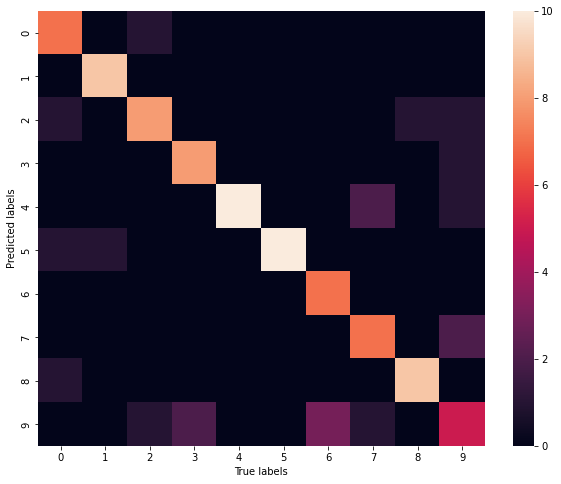

In [32]:
predictions = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T)#, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [33]:
model.save('/gdrive/MyDrive/polimi/NAML/NAML_proj/models/transfer_learning/tl_complete')

INFO:tensorflow:Assets written to: /gdrive/MyDrive/polimi/NAML/NAML_proj/models/transfer_learning/tl_complete/assets


INFO:tensorflow:Assets written to: /gdrive/MyDrive/polimi/NAML/NAML_proj/models/transfer_learning/tl_complete/assets
